In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
!pip install pydicom
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

     |████████████████████████████████| 2.0 MB 15.3 MB/s 


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle competitions download rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [01:13<00:00, 62.3MB/s]
100% 3.66G/3.66G [01:13<00:00, 53.6MB/s]


In [ ]:
! unzip rsna-pneumonia-detection-challenge

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_trai

## Data Preprocessing

In [ ]:
data = pd.read_csv('stage_2_train_labels.csv').filter(['patientId', 'Target'])
data.head(5)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [ ]:
train_labels, val_labels = train_test_split(data.values, test_size=0.1)
print(train_labels.shape)
print(val_labels.shape)

(27204, 2)
(3023, 2)


In [ ]:
train_paths = [os.path.join('stage_2_train_images', image[0]) for image in train_labels]
val_paths = [os.path.join('stage_2_test_images', image[0]) for image in val_labels]

## Data Samples

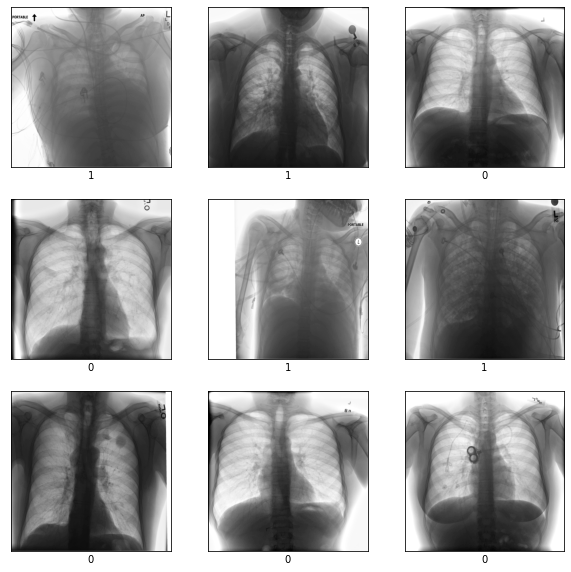

In [ ]:
def show(n=9):
    plt.figure(figsize=(10,10))
    for i in range(n):
        plt.xticks([])
        plt.yticks([])
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        plt.imshow(img_dcm.pixel_array, cmap=plt.cm.binary)
        plt.xlabel(train_labels[i+20][1])
show()

## Composing transformations

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()
])

## Formatted Dataset 

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0
        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')
        label = self.labels[index][1]
        if self.transform is not None:
            image = self.transform(image)
        return image, label
        
    def __len__(self):
        return len(self.paths)

Tensor:tensor([[[0.1765, 0.1725, 0.1686,  ..., 0.2118, 0.2235, 0.2431],
         [0.1412, 0.1373, 0.1333,  ..., 0.1765, 0.1843, 0.2000],
         [0.1216, 0.1176, 0.1137,  ..., 0.1569, 0.1647, 0.1725],
         ...,
         [0.7843, 0.7804, 0.7804,  ..., 0.0980, 0.1059, 0.1176],
         [0.8000, 0.7961, 0.7882,  ..., 0.1020, 0.1137, 0.1255],
         [0.7961, 0.7961, 0.7922,  ..., 0.1059, 0.1176, 0.1333]],

        [[0.1765, 0.1725, 0.1686,  ..., 0.2118, 0.2235, 0.2431],
         [0.1412, 0.1373, 0.1333,  ..., 0.1765, 0.1843, 0.2000],
         [0.1216, 0.1176, 0.1137,  ..., 0.1569, 0.1647, 0.1725],
         ...,
         [0.7843, 0.7804, 0.7804,  ..., 0.0980, 0.1059, 0.1176],
         [0.8000, 0.7961, 0.7882,  ..., 0.1020, 0.1137, 0.1255],
         [0.7961, 0.7961, 0.7922,  ..., 0.1059, 0.1176, 0.1333]],

        [[0.1765, 0.1725, 0.1686,  ..., 0.2118, 0.2235, 0.2431],
         [0.1412, 0.1373, 0.1333,  ..., 0.1765, 0.1843, 0.2000],
         [0.1216, 0.1176, 0.1137,  ..., 0.1569, 0.1

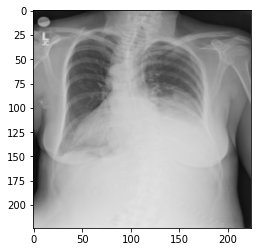

In [ ]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
image = iter(train_dataset)
img, label = next(image)
print(f'Tensor:{img}, Label:{label}')
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

## Train image shape

In [ ]:
img.shape

torch.Size([224, 224, 3])

## Load Training and Testing Dataset

In [ ]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)

## Check dataloader

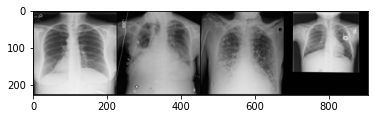

In [ ]:
batch = iter(train_loader)
images, labels = next(batch)

image_grid = torchvision.utils.make_grid(images[:4])
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))
plt.imshow(img)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
!nvidia-smi

Mon Apr 25 01:42:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load pre-trained SwinTransformer and fine-tune

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 12.1 MB/s 
     |████████████████████████████████| 596 kB 43.8 MB/s 
     |████████████████████████████████| 6.6 MB 49.5 MB/s 
     |████████████████████████████████| 895 kB 46.3 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 12.7 MB/s 


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoFeatureExtractor, SwinModel, SwinConfig
from timm import create_model
model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth


In [ ]:
# model.encoder.layers[3].blocks[1].output.dense = nn.Linear(in_features=3072, out_features=2, bias=True)
#model.layernorm=nn.LayerNorm((768,2), eps=1e-05, elementwise_affine=True)

In [ ]:
model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      dim=192, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
     

## Write a train code and RUN

In [ ]:
torch.cuda.empty_cache()
# Train the model
total_step = len(train_loader)
for epoch in range(10):
    # Training
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 2000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))


    # Validation
    correct = 0
    total = 0  
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()
    print(f'Epoch: {epoch+1}/{num_epochs}, Val_Acc: {100*correct/total}')

2000it [19:33,  1.70it/s]

Epoch [1/10], Step [2000/3401], Loss: 0.6130


3401it [33:10,  1.71it/s]
100%|██████████| 378/378 [01:31<00:00,  4.15it/s]


Epoch: 1/10, Val_Acc: 82.63314819335938


2000it [19:22,  1.71it/s]

Epoch [2/10], Step [2000/3401], Loss: 1.1528


3401it [32:55,  1.72it/s]
100%|██████████| 378/378 [01:29<00:00,  4.21it/s]


Epoch: 2/10, Val_Acc: 83.29473876953125


2000it [19:15,  1.71it/s]

Epoch [3/10], Step [2000/3401], Loss: 0.6547


3401it [32:42,  1.73it/s]
100%|██████████| 378/378 [01:25<00:00,  4.41it/s]


Epoch: 3/10, Val_Acc: 84.55177307128906


2000it [19:06,  1.75it/s]

Epoch [4/10], Step [2000/3401], Loss: 0.5163


3401it [32:30,  1.74it/s]
100%|██████████| 378/378 [01:25<00:00,  4.43it/s]


Epoch: 4/10, Val_Acc: 84.61792755126953


2000it [19:03,  1.74it/s]

Epoch [5/10], Step [2000/3401], Loss: 0.1231


3401it [32:25,  1.75it/s]
100%|██████████| 378/378 [01:25<00:00,  4.40it/s]


Epoch: 5/10, Val_Acc: 85.54415893554688


2000it [19:08,  1.73it/s]

Epoch [6/10], Step [2000/3401], Loss: 0.0104


3401it [32:32,  1.74it/s]
100%|██████████| 378/378 [01:25<00:00,  4.41it/s]


Epoch: 6/10, Val_Acc: 85.67648315429688


2000it [19:03,  1.75it/s]

Epoch [7/10], Step [2000/3401], Loss: 0.0024


3401it [32:24,  1.75it/s]
100%|██████████| 378/378 [01:26<00:00,  4.35it/s]


Epoch: 7/10, Val_Acc: 86.43731689453125


2000it [19:04,  1.74it/s]

Epoch [8/10], Step [2000/3401], Loss: 0.0184


3401it [32:24,  1.75it/s]
100%|██████████| 378/378 [01:26<00:00,  4.38it/s]


Epoch: 8/10, Val_Acc: 87.3966293334961


2000it [19:07,  1.73it/s]

Epoch [9/10], Step [2000/3401], Loss: 0.0363


3401it [32:35,  1.74it/s]
100%|██████████| 378/378 [01:27<00:00,  4.34it/s]


Epoch: 9/10, Val_Acc: 86.83427429199219


2000it [19:18,  1.70it/s]

Epoch [10/10], Step [2000/3401], Loss: 0.1638


3401it [32:54,  1.72it/s]
100%|██████████| 378/378 [01:30<00:00,  4.20it/s]

Epoch: 10/10, Val_Acc: 87.892822265625


In [ ]:
#remedy recording losses and accuracies shown above
losses=[0.6130, 1.1528, 0.6547, 0.5163, 0.1231, 0.0104, 0.0024, 0.0184, 0.0363, 0.1638]
accuracies=[82.63314819335938, 83.29473876953125, 84.55177307128906, 84.61792755126953, 85.54415893554688, 85.67648315429688, 86.43731689453125, 87.3966293334961, 86.83427429199219, 87.892822265625]

In [ ]:
#torch.save(model.state_dict(), "swinTransformer.pt")

In [ ]:
# swin = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=2)
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# swin.to(device)
# swin.load_state_dict(torch.load("swinTransformer.pt"))

In [ ]:
# print(torch.__version__)

In [ ]:
# swin.eval()


# correct = 0
# total = 0  
# for images, labels in tqdm(train_loader):
#     images = images.to(device)
#     labels = labels.to(device)
#     predictions = swin(images)
#     _, predicted = torch.max(predictions, 1)
#     total += labels.size(0)
#     correct += (labels == predicted).sum()
# print(f'Val_Acc: {100*correct/total}')

In [ ]:
swin=model

## Test model

In [ ]:
swin.eval()
preds = []
labels = []
with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.max(swin(data),1)[1].item()
        preds.append(pred)
        labels.append(label)

100%|██████████| 3023/3023 [02:45<00:00, 18.26it/s]


In [ ]:
preds.count(preds[0]) == len(preds)

False

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
acc = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
cm = confusion_matrix(labels, preds)

print(f"Val Accuracy {acc}")
print(f"Val precision {precision}")
print(f"Val Recall {recall}")
print(f"Val F1 {f1}")
print(f"Confusion Matrix {cm}")

Val Accuracy 0.8785974197816738
Val precision 0.8073593073593074
Val Recall 0.7978609625668449
Val F1 0.8025820333512642
Confusion Matrix [[1910  178]
 [ 189  746]]


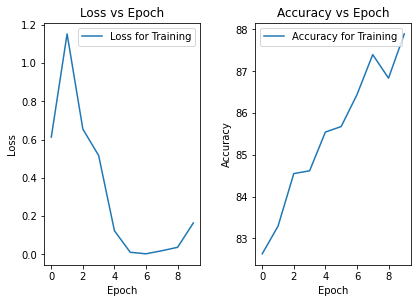

In [ ]:
import matplotlib.pyplot as plt
fig, (a, b) = plt.subplots(1, 2)
def plot(a, m, text):
  a.plot(list(range(10)), m, label=text+" for Training")
  a.set_xlabel('Epoch')
  a.set_ylabel(text)
  a.set_title(text + " vs Epoch")
  a.legend()
plot(a, losses, "Loss")
plot(b, accuracies, "Accuracy")
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()